In [1]:
import numpy as np
import scipy as sc
import scipy.sparse as sparse
import csv  
import datetime
import time
import sys
from scipy.sparse.linalg import expm_multiply
import concurrent.futures
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import sqrtm


In [3]:
pauli_x = sparse.csr_matrix(np.array([[0,1],[1,0]]))
pauli_y = sparse.csr_matrix(np.array([[0,-1j],[1j,0]]))
pauli_z = sparse.csr_matrix(np.array([[1,0],[0,-1]]))
I = sparse.csr_matrix(np.eye(2))

    
def generate_op_at_site(L,site,operator):
    op = I
    for i in range(L):
        if i==site:
            current_op=operator
        else:
            current_op=I
        op = sparse.kron(op,current_op, format = "csr") if i!= 0 else current_op
    return op

def generate_paulis(L):
    X=[]
    Y=[]
    Z=[]
    for i in range(L): 
        X.append(generate_op_at_site(L,i,pauli_x))
        Y.append(generate_op_at_site(L,i,pauli_y))
        Z.append(generate_op_at_site(L,i,pauli_z))
    return X,Y,Z
    
#ZZX convention
def generate_TFI(L,h,X,Y,Z):
    H=0
    for i in range(L):
        H+=-Z[i]@Z[int((i+1)%L)]-h*X[i]
    return H
#XXZ convention
def generate_TFI_XXZ(L,h,X,Y,Z):
    H=0
    for i in range(L-1):
        H+=-X[i]@X[int((i+1)%L)]
    for i in range(L):
        H+=-h*Z[i]
    return H

def generate_P2(L,J,p,s,X,Y,Z):
    H=0
    for i in range(L):
        H+=2*J*(sparse.csr_matrix(np.eye(2**L))-Z[i]@Z[int((i+1)%L)])+p*s/2*(sparse.csr_matrix(np.eye(2**L))-X[i])
    return H





def generate_forward_backward(L):
    X,Y,Z = generate_paulis(L)
    Zf = []
    Xf = []
    Yf = []
        
    Zb = []
    Xb = []
    Yb = []

    I_single = sparse.csr_matrix(np.eye(2**L))
    for i in range(L):
        Xf.append(sparse.kron(I_single,X[i], format = "csr"))
        Yf.append(sparse.kron(I_single,Y[i], format = "csr"))
        Zf.append(sparse.kron(I_single,Z[i], format = "csr"))
        Xb.append(sparse.kron(X[i],I_single, format = "csr"))
        Yb.append(sparse.kron(Y[i],I_single, format = "csr"))
        Zb.append(sparse.kron(Z[i],I_single, format = "csr"))
    return Xf,Yf,Zf,Xb,Yb,Zb

def generate_full_P2(L,J,U,p,s,Xf,Yf,Zf,Xb,Yb,Zb):
    P2=0
    I_double=sparse.csr_matrix(np.eye(2**(2*L)))
    for i in range(L):
        P2+= 2*J*(I_double-Zf[i]@Zb[i]@Zf[int((i+1)%L)]@Zb[int((i+1)%L)])
    for i in range(L):
        P2+=2*U*(I_double-Xf[i]@Xb[i])+p*(s-2)/4*((s+2)/(s-2)*I_double-Xf[i]@Xb[i])-p*s/4*(Xf[i]+Xb[i])
    return P2
def generate_P2_2(L,J,p,s,X,Y,Z):
    H=0
    for i in range(L-1):
        H+=-2*J*(Z[i]@Z[int((i+1))])
    for i in range(L):
        H+=-p*s/2*X[i]
    return H

def get_TFI_cor(L,h_array):
    X,Y,Z = generate_paulis(L)
    cor = []
    for h in h_array:
        H = generate_TFI(L,h,X,Y,Z)
        w,v = sparse.linalg.eigsh(H,k=2,which = "SA")
        cor.append(v[:,0].transpose()@Z[0]@Z[int(L/2)]@v[:,0]/np.linalg.norm(v[:,0])**2)
    return np.array(cor)
    

In [4]:
X,Y,Z = generate_paulis(4)
L=4
ps = [0,4,8,12]

T = np.linspace(0,1,100)
x_pol = 1/np.sqrt(2)**L*np.ones(2**L).transpose()
cors_diag=np.zeros((len(ps),len(T)))
for i,p in enumerate(ps):
    P2=generate_P2(L,1,p,0.5,X,Y,Z)
    for j,t in enumerate(T):
        state = expm_multiply(-t*P2,x_pol)
        cors_diag[i,j]=state.transpose().conj()@Z[0]@Z[int(L/2)]@state/np.linalg.norm(state)**2

In [5]:
X,Y,Z = generate_paulis(4)
L=4
ps = np.linspace(0,16,100)

cors=[]
for i,p in enumerate(ps):
    P2=generate_P2(L,1,p,0.5,X,Y,Z)
    E,state= sparse.linalg.eigsh(P2,k=1, which = "SM")
    cors.append(state[:,0].transpose().conj()@Z[0]@Z[int(L/2)]@state[:,0])

In [7]:
cors

[0.9999999999999999,
 0.9998979071422234,
 0.999590879546036,
 0.9990766732411579,
 0.9983515587613688,
 0.9974103374171472,
 0.9962463651622304,
 0.9948515851204303,
 0.9932165701146696,
 0.9913305767901763,
 0.9891816131378928,
 0.9867565213901106,
 0.9840410783635061,
 0.9810201153480057,
 0.9776776595646007,
 0.9739970990214202,
 0.9699613722654321,
 0.9655531840391582,
 0.9607552471939311,
 0.9555505503761789,
 0.9499226499931117,
 0.9438559837936739,
 0.9373362020991991,
 0.930350511333017,
 0.9228880230939496,
 0.9149401006774236,
 0.9065006937661102,
 0.8975666510946687,
 0.8881380003465207,
 0.8782181844616348,
 0.8678142440003493,
 0.856936936264809,
 0.8456007835314376,
 0.8338240449518306,
 0.8216286093425267,
 0.8090398090670674,
 0.7960861583401311,
 0.7827990223543637,
 0.7692122264427775,
 0.755361616855005,
 0.7412845864904146,
 0.7270195799894434,
 0.7126055928888924,
 0.6980816791102125,
 0.6834864799405672,
 0.6688577859998053,
 0.6542321416085893,
 0.63964449864637

In [8]:
def get_fid_cor(U,J,s,p,L,Nt,Tmax):
    T = np.linspace(0,1.5,Nt)
    dt = Tmax/Nt
    X,Y,Z = generate_paulis(L)
    Xf,Yf,Zf,Xb,Yb,Zb=generate_forward_backward(L)
    P2_full=generate_full_P2(L,J,U,p,s,Xf,Yf,Zf,Xb,Yb,Zb)
    x_pol_double = 1/np.sqrt(2)**(2*L)*np.ones(2**(2*L)).transpose()
    fid_cor=[]
    state = x_pol_double
    density = state.copy().reshape((2**L,2**L))
    sqrtd = sqrtm(density,blocksize=2)
    fid_cor.append(np.trace(sqrtm(sqrtd@Z[0]@Z[int(L/2)]@density@Z[int(L/2)]@Z[0]@sqrtd)))
    for t in range(Nt-1):
        state = expm_multiply(-dt*P2_full,state)
        density = state.copy().reshape((2**L,2**L))
        dn = density/np.trace(density)
        dn[np.abs(dn)<0.0001]=0

        state = state/np.trace(density)
        sqrtd = sqrtm(dn,blocksize=4)
        fid_cor.append(np.trace(sqrtm(sqrtd@Z[0]@Z[int(L/2)]@dn@Z[int(L/2)]@Z[0]@sqrtd)))
    return fid_cor   

In [9]:
fid_cor_4=get_fid_cor(1,1,0.5,4,4,100,1)

In [10]:
fid_cor_8=get_fid_cor(1,1,0.5,8,4,100,1)


In [11]:
fid_cor_12=get_fid_cor(1,1,0.5,12,4,100,1)

In [12]:
fid_cor_0=get_fid_cor(1,1,0.5,0,4,100,1)

In [13]:
fid_cor_8=get_fid_cor(1,1,0.5,8,4,100,1)

In [14]:
fid_cor_14=get_fid_cor(1,1,0.5,14,4,100,1)
fid_cor_16=get_fid_cor(1,1,0.5,16,4,100,1)

C:\Users\nzier\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\nzier\miniconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


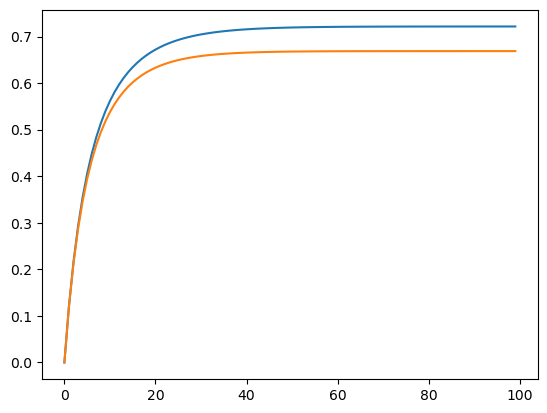

In [45]:
fig, ax = plt.subplots(1)
ax.plot(fid_cor_14)
ax.plot(fid_cor_16)

In [15]:
L=4
#data0=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\L4_p0_4_10e4.csv",skiprows=[0])
data4=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\Renyi2\R2_and_Fid\p4.csv",skiprows=[0])
data8=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\Renyi2\R2_and_Fid\p8.csv",skiprows=[0])
data12=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\Renyi2\R2_and_Fid\p12.csv",skiprows=[0])
data2=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\Renyi2\R2_and_Fid\p2.csv",skiprows=[0])
data6=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\Renyi2\R2_and_Fid\p6.csv",skiprows=[0])
data10=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\Renyi2\R2_and_Fid\p10.csv",skiprows=[0])
data14=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\Renyi2\R2_and_Fid\p14.csv",skiprows=[0])
data16=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\Renyi2\R2_and_Fid\p16.csv",skiprows=[0])


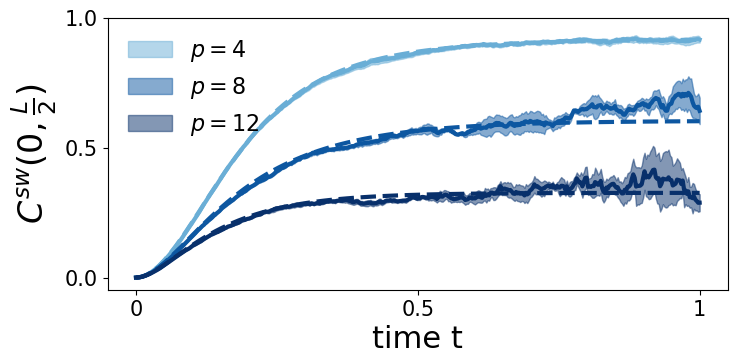

In [16]:
fig, ax=plt.subplots(1,figsize = (8,4))
t_diag = np.linspace(0,1,100)
t_sim=np.linspace(0,1,400)
colors = plt.get_cmap("Blues")(np.linspace(0.5, 1.2, 3))
'''
ax.plot(t_sim,data0["R2"])
ax.plot(t_sim,np.abs(data0["R2"]),color = colors[0])
ax.plot(t_diag,cors_diag[0,:], linestyle = "dashed",color = colors[0])
ax.fill_between(t_sim,np.abs(data0["R2"]+data0["R2_std"]),np.abs(data0["R2"]-data0["R2_std"]), alpha = 0.5, label = r"$p=0$",color = colors[0])
'''

ax.plot(t_sim,data4["R2"])
ax.plot(t_sim,np.abs(data4["R2"]),color = colors[0], linewidth = 3)
ax.plot(t_diag,cors_diag[1,:], linestyle = "dashed",color = colors[0],linewidth = 3)
ax.fill_between(t_sim,np.abs(data4["R2"]+data4["R2_std"]),np.abs(data4["R2"]-data4["R2_std"]), alpha = 0.5, label = r"$p=4$",color = colors[0])

ax.plot(t_sim,data8["R2"])
ax.plot(t_sim,np.abs(data8["R2"]),color = colors[1], linewidth = 3)
ax.plot(t_diag,cors_diag[2,:], linestyle = "dashed",color = colors[1],linewidth = 3)
ax.fill_between(t_sim,np.abs(data8["R2"]+data8["R2_std"]),np.abs(data8["R2"]-data8["R2_std"]), alpha = 0.5, label = r"$p=8$",color = colors[1])

ax.plot(t_sim,data12["R2"])
ax.plot(t_sim,np.abs(data12["R2"]),color = colors[2], linewidth = 3)
ax.plot(t_diag,cors_diag[3,:], linestyle = "dashed",color = colors[2],linewidth = 3)
ax.fill_between(t_sim,np.abs(data12["R2"]+data12["R2_std"]),np.abs(data12["R2"]-data12["R2_std"]), alpha = 0.5, label = r"$p=12$",color = colors[2])

ax.legend(fontsize = 16, frameon= False)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 15)
ax.set_xlabel("time t", fontsize = 22)
ax.set_ylabel(r"$C^{sw}(0,\frac{L}{2})$", fontsize = 24)
plt.gcf().subplots_adjust(bottom=0.20)

fig.savefig(r"C:\Users\nzier\Documents\QuantumActiveMatter\QuantumCircuits\figs\R2_time_dependent_long.pdf", format = "pdf")


In [17]:

# Compute weights as inverse variance
weights = 1.0 / (data12["R2_std"][250:] ** 2)

# Weighted average
avg = np.sum(weights * data12["R2"][250:]) / np.sum(weights)

# Weighted standard deviation of the mean
std = np.sqrt(1.0 / np.sum(weights))

In [18]:
data = data16
print(data["R2"][250:].mean())
print(data["R2"][250:].std())

0.15656852740049357
0.034314232379727465


In [5]:
avgs=[1.0,0.9804555900096894,0.908489904244741,0.758031086285909,0.6357701892058054,0.41825877861181887,0.35004038588205966,0.24500787035624186,0.15656852740049357]
stds=[0.00001,0.0021153655591834124,0.00679680628518574,0.01568334509156803,0.037182679167106866,0.026555675125639045,0.023918625745754363,0.018051464842627853,0.034314232379727465]

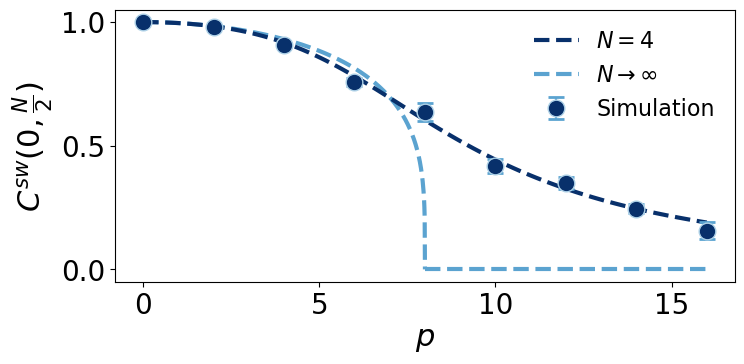

In [8]:
ps=[0,2,4,6,8,10,12,14,16]
colors = plt.get_cmap("Blues")(np.linspace(0.1, 1.0, 5))
p_cont=np.linspace(0,16,100)
p_half=np.linspace(0,8,1000)
p_half2=np.linspace(8,16,1000)
fig, ax = plt.subplots(1,figsize = (8,4))
#ax.scatter(ps,avgs,marker="o", color=colors[4], edgecolor=colors[1], linewidth = 1, label = "Simulation", s = 60,zorder = 4)
ax.errorbar(x=ps,y=avgs,yerr=stds,marker="o",markerfacecolor =colors[4],markeredgecolor = colors[1],markersize = 12 ,label = "Simulation",zorder = 3,solid_capstyle='projecting', capsize=6, capthick = 2,linestyle='None',color=colors[2])
ax.plot(p_cont,cors,color=colors[4], linestyle = "dashed", linewidth = 3, label = r"$N=4$",zorder = 2)
ax.plot(p_half,(1-(p_half/8)**2)**(1/4), color=colors[2],linestyle = "dashed", linewidth = 3,label =r"$N \to \infty$",zorder = 1)
ax.plot(p_half2,np.zeros(1000), color=colors[2],linestyle = "dashed", linewidth = 3,zorder = 1)
ax.set_yticks([0,0.5,1])
ax.tick_params(labelsize = 20)
ax.set_xlabel("$p$", fontsize = 22)
ax.set_ylabel(r"$C^{sw}(0,\frac{N}{2})$", fontsize = 22)
ax.legend(fontsize = 16, frameon = False)
plt.gcf().subplots_adjust(bottom=0.20)
fig.savefig(r"C:\Users\nzier\Documents\QuantumActiveMatter\QuantumCircuits\figs\R2_steady_state.pdf", format = "pdf")


In [59]:
data4_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p4_4_10e4.csv",skiprows=[0])

In [60]:
data8_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p8_4_10e4.csv",skiprows=[0])
data12_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p12_4_10e4.csv",skiprows=[0])


C:\Users\nzier\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\nzier\miniconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


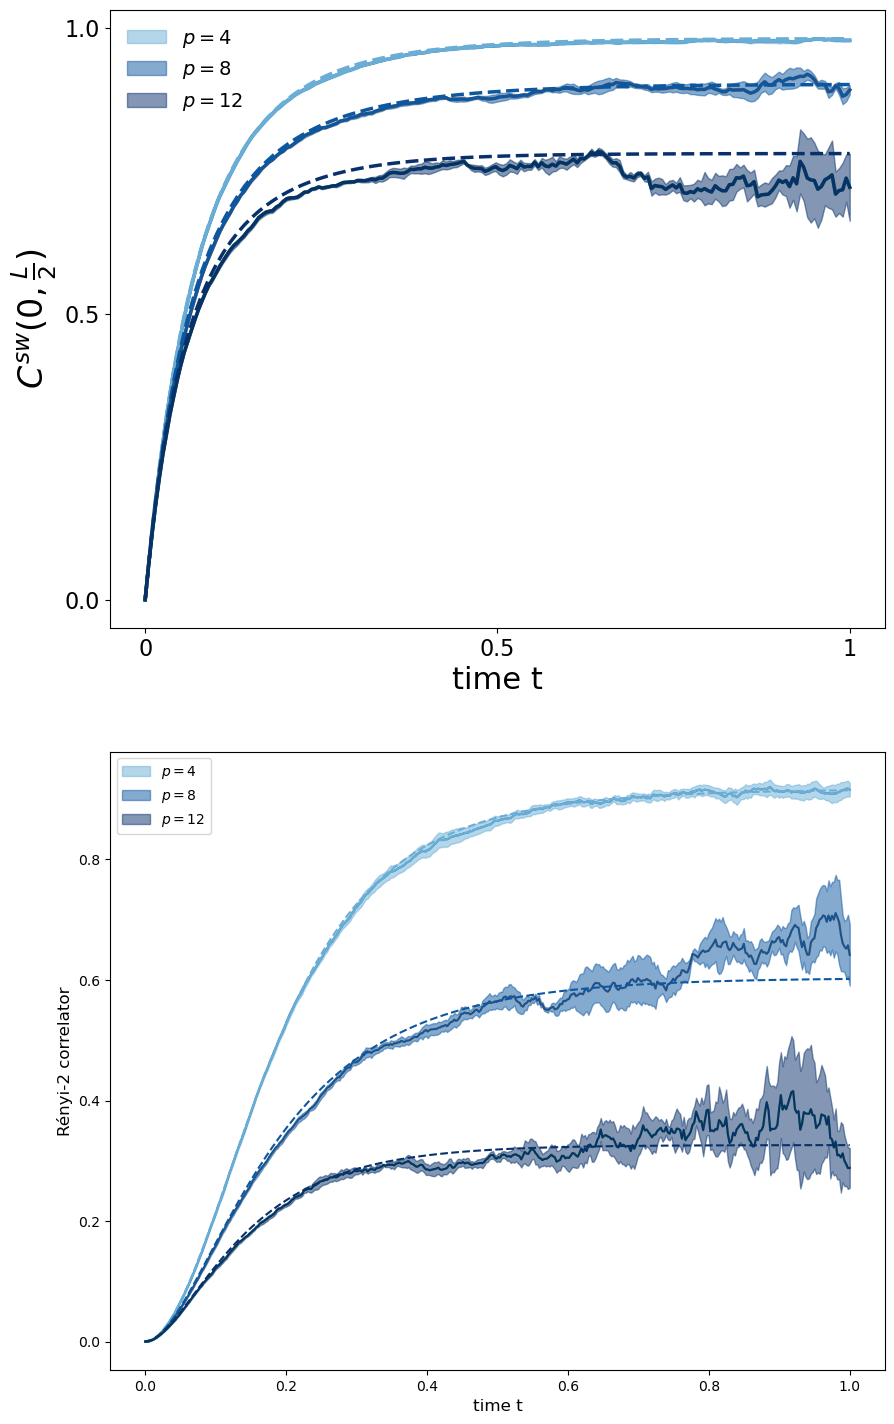

In [69]:
fig, ax=plt.subplots(2,figsize = (10,10), sharex=False)
t_diag = np.linspace(0,1,100)
t_sim=np.linspace(0,1,200)
colors = plt.get_cmap("Blues")(np.linspace(0.5, 1.2, 3))

#ax.plot(t_sim,data0["fid"])
#ax.plot(t_sim,np.abs(data0["fid"]),color = colors[0])
#ax.plot(t_diag,fid_cor_0, linestyle = "dashed",color = colors[0])
#ax.fill_between(t_sim,np.abs(data0["fid"]+data0["fid_std"]),np.abs(data0["fid"]-data0["fid_std"]), alpha = 0.5, label = r"$p=4$",color = colors[0])

ax[0].plot(t_sim,data4_fid["fid"], linewidth = 2.5)
ax[0].plot(t_sim,np.abs(data4_fid["fid"]),color = colors[0], linewidth = 2.5)
ax[0].plot(t_diag,fid_cor_4, linestyle = "dashed",color = colors[0], linewidth = 2.5)
ax[0].fill_between(t_sim,np.abs(data4_fid["fid"]+data4_fid["fid_std"]),np.abs(data4_fid["fid"]-data4_fid["fid_std"]), alpha = 0.5, label = r"$p=4$",color = colors[0])

ax[0].plot(t_sim,data8_fid["fid"], linewidth = 2.5)
ax[0].plot(t_sim,np.abs(data8_fid["fid"]),color = colors[1], linewidth = 2.5)
ax[0].plot(t_diag,fid_cor_8, linestyle = "dashed",color = colors[1], linewidth = 2.5)
ax[0].fill_between(t_sim,np.abs(data8_fid["fid"]+data8_fid["fid_std"]),np.abs(data8_fid["fid"]-data8_fid["fid_std"]), alpha = 0.5, label = r"$p=8$",color = colors[1])

ax[0].plot(t_sim,data12_fid["fid"], linewidth = 2.5)
ax[0].plot(t_sim,np.abs(data12_fid["fid"]),color = colors[2], linewidth = 2.5)
ax[0].plot(t_diag,fid_cor_12, linestyle = "dashed",color = colors[2], linewidth = 2.5)
ax[0].fill_between(t_sim,np.abs(data12_fid["fid"]+data12_fid["fid_std"]),np.abs(data12_fid["fid"]-data12_fid["fid_std"]), alpha = 0.5, label = r"$p=12$",color = colors[2])

ax[0].legend(loc=2)
ax[0].set_ylabel(r"Fidelity correlator", fontsize = 12)

ax[0].set_xlabel("time t", fontsize = 22)
ax[0].set_ylabel(r"$C^{sw}(0,\frac{L}{2})$", fontsize = 24)

ax[0].legend(fontsize = 14, frameon= False)
ax[0].set_yticks([0,0.5,1])
ax[0].set_xticks([0,0.5,1.0])
ax[0].set_xticklabels(["0","0.5","1"])
ax[0].tick_params(labelsize = 16)

plt.gcf().subplots_adjust(bottom=0.20)


t_sim=np.linspace(0,1,400)

ax[1].plot(t_sim,data4["R2"])
ax[1].plot(t_sim,np.abs(data4["R2"]),color = colors[0])
ax[1].plot(t_diag,cors_diag[1,:], linestyle = "dashed",color = colors[0])
ax[1].fill_between(t_sim,np.abs(data4["R2"]+data4["R2_std"]),np.abs(data4["R2"]-data4["R2_std"]), alpha = 0.5, label = r"$p=4$",color = colors[0])

ax[1].plot(t_sim,data8["R2"])
ax[1].plot(t_sim,np.abs(data8["R2"]),color = colors[1])
ax[1].plot(t_diag,cors_diag[2,:], linestyle = "dashed",color = colors[1])
ax[1].fill_between(t_sim,np.abs(data8["R2"]+data8["R2_std"]),np.abs(data8["R2"]-data8["R2_std"]), alpha = 0.5, label = r"$p=8$",color = colors[1])

ax[1].plot(t_sim,data12["R2"])
ax[1].plot(t_sim,np.abs(data12["R2"]),color = colors[2])
ax[1].plot(t_diag,cors_diag[3,:], linestyle = "dashed",color = colors[2])
ax[1].fill_between(t_sim,np.abs(data12["R2"]+data12["R2_std"]),np.abs(data12["R2"]-data12["R2_std"]), alpha = 0.5, label = r"$p=12$",color = colors[2])

ax[1].legend()
ax[1].set_xlabel("time t", fontsize = 12)
ax[1].set_ylabel(r"Rényi-2 correlator", fontsize = 12)

fig.savefig(r"C:\Users\nzier\Documents\QuantumActiveMatter\QuantumCircuits\figs\Fidelity_R2_time_dependent", format = "pdf")

In [30]:
data2_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p2_4_10e4.csv",skiprows=[0])
data4_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p4_4_10e4.csv",skiprows=[0])
data6_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p6_4_10e4.csv",skiprows=[0])
data8_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p8_4_10e4.csv",skiprows=[0])
data12_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p12_4_10e4.csv",skiprows=[0])
data14_fid=pd.read_csv(r"C:\Users\nzier\Documents\QuantumActiveMatter\Paper_simulations\fidelity\L4_p14_4_10e4.csv",skiprows=[0])


In [40]:
avgs=[]
stds=[]
ps=[2,4,6,8,12,14]
avgs.append(data2_fid["fid"][200:400].mean())
avgs.append(data4_fid["fid"][100:200].mean())
avgs.append(data6_fid["fid"][200:400].mean())
avgs.append(data8_fid["fid"][100:200].mean())
avgs.append(data12_fid["fid"][100:200].mean())
avgs.append(data14_fid["fid"][200:400].mean())

stds.append(data2_fid["fid"][200:400].std())
stds.append(data4_fid["fid"][100:200].std())
stds.append(data6_fid["fid"][200:400].std())
stds.append(data8_fid["fid"][100:200].std())
stds.append(data12_fid["fid"][100:200].std())
stds.append(data14_fid["fid"][200:400].std())

In [42]:
J=1
U=1
s=0.5
field_names=["L","J","U","s"]
fields=[4,1,1,1]
file_name=r"C:\Users\nzier\Documents\QuantumActiveMatter\QuantumCircuits\fidelity_steady_state.csv"
with open(file_name, 'a') as f:
    writer = csv.writer(f)
    writer.writerow(field_names)
    writer.writerow(fields)
    

data = {
"avgs": np.abs(np.array(avgs)),
"stds": np.abs(np.array(stds)),
"p": ps,
}

df = pd.DataFrame(data)

# Specify the CSV file name


# Append the DataFrame to the CSV file without overwriting
df.to_csv(file_name, mode='a', index=False, header=False)

C:\Users\nzier\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\nzier\miniconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


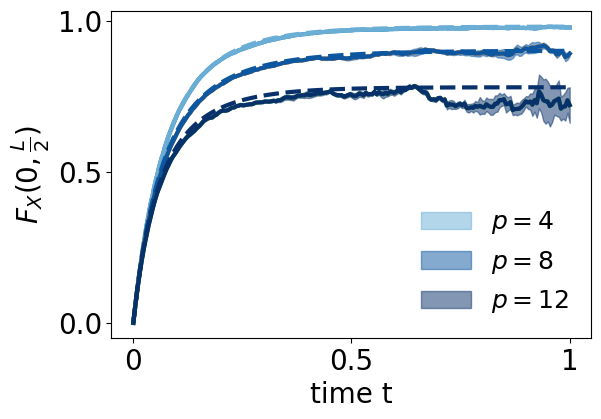

In [78]:
fig, ax=plt.subplots(1)
t_diag = np.linspace(0,1,100)
t_sim=np.linspace(0,1,200)
colors = plt.get_cmap("Blues")(np.linspace(0.5, 1.2, 3))

#ax.plot(t_sim,data0["fid"])
#ax.plot(t_sim,np.abs(data0["fid"]),color = colors[0])
#ax.plot(t_diag,fid_cor_0, linestyle = "dashed",color = colors[0])
#ax.fill_between(t_sim,np.abs(data0["fid"]+data0["fid_std"]),np.abs(data0["fid"]-data0["fid_std"]), alpha = 0.5, label = r"$p=4$",color = colors[0])

ax.plot(t_sim,data4_fid["fid"], linewidth = 3)
ax.plot(t_sim,np.abs(data4_fid["fid"]),color = colors[0], linewidth = 3)
ax.plot(t_diag,fid_cor_4, linestyle = "dashed",color = colors[0], linewidth = 3)
ax.fill_between(t_sim,np.abs(data4_fid["fid"]+data4_fid["fid_std"]),np.abs(data4_fid["fid"]-data4_fid["fid_std"]), alpha = 0.5, label = r"$p=4$",color = colors[0])

ax.plot(t_sim,data8_fid["fid"], linewidth = 3)
ax.plot(t_sim,np.abs(data8_fid["fid"]),color = colors[1], linewidth = 3)
ax.plot(t_diag,fid_cor_8, linestyle = "dashed",color = colors[1], linewidth = 3)
ax.fill_between(t_sim,np.abs(data8_fid["fid"]+data8_fid["fid_std"]),np.abs(data8_fid["fid"]-data8_fid["fid_std"]), alpha = 0.5, label = r"$p=8$",color = colors[1])

ax.plot(t_sim,data12_fid["fid"], linewidth = 3)
ax.plot(t_sim,np.abs(data12_fid["fid"]),color = colors[2], linewidth = 3)
ax.plot(t_diag,fid_cor_12, linestyle = "dashed",color = colors[2], linewidth = 3)
ax.fill_between(t_sim,np.abs(data12_fid["fid"]+data12_fid["fid_std"]),np.abs(data12_fid["fid"]-data12_fid["fid_std"]), alpha = 0.5, label = r"$p=12$",color = colors[2])


ax.set_ylabel(r"Fidelity correlator", fontsize = 20)

ax.set_xlabel("time t", fontsize = 20)
ax.set_ylabel(r"$F_X(0,\frac{L}{2})$", fontsize = 20)

ax.legend(fontsize = 18 ,frameon= False)
ax.set_yticks([0,0.5,1])
ax.set_xticks([0,0.5,1.0])
ax.set_xticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 20)

plt.gcf().subplots_adjust(bottom=0.20)

plt.gcf().subplots_adjust(left=0.15)
fig.savefig(r"C:\Users\nzier\Documents\QuantumActiveMatter\QuantumCircuits\figs\Fidelity_time_dependent.pdf", format = "pdf")